

# Project 6

### Exploring Solutions to the Time-Independent Schrödinger Equation
 
#### Written by Owen Morehead - 5/30/2020



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.integrate as integrate
%matplotlib inline

## Finite Square Well with the Time-Independent Schrödinger Equation

Time-Independent Schrödinger Equation:

$$\begin{align}
i\hbar \ \frac{\partial\psi(x,t)}{\partial t} & =
\hat{H}\psi(x,t)\\
i\hbar \ \frac{\partial\psi(x,t)}{\partial t} & =   - \frac{\hbar^2} {2m}
\frac{\partial^2 \psi(x,t)}{\partial x^2}
+V(x)\psi(x,t)\end{align}$$

Set $\hbar^2/2m=1$ and $\hbar=1$ for simplicity.

Here we explore the finite square well. We find both eigenvalues and plot the corresponding wave functions of the three lowest-energy states.

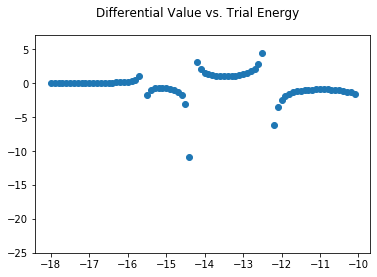

In [17]:
def V(x):
    """Finite square well potential function
    """
#    if (x>0): print("V is given positive x:",x)
    if (abs(x) < 10.):  return (-16.0)                        # Well depth
    else:               return (0.)


def f(y, x, k2fac,E):
    """Schrodinger equation
    """
    return [y[1],-k2fac*(E-V(x))*y[0]]

def diff(E, k2fac, xs, imatch, icount, Lwf, Rwf):
# start on the left.
    Lwf[icount,0,0] = 1.e-5                                      
    Lwf[icount,0,1]= Lwf[icount,0,0]*np.sqrt(k2fac*abs(E))
    state = ([Lwf[icount,0,0], Lwf[icount,0,1]])
    Lwf[icount,:,:] = integrate.odeint(f, state, xs[0:len(Lwf[0,:,0])], args=(k2fac,E))
#   now the right side. odeint doesn't integrate backwards well, apparently, so flip by hand:
    yb=np.zeros((2,len(Rwf[0,:,0])))
    yb[0,0] = 1.e-5                                      
    yb[0,1]=  yb[0,0]*np.sqrt(k2fac*abs(E)) # no minus sign for the slope, as it's already going backward
    state = ([yb[0,0],yb[0,1]])
    xb=-xs[:(len(Lwf[0,:,0])-2):-1]
    yb = integrate.odeint(f, state,xb, args=(k2fac,E)) # step backward to imatch
    Rwf[icount,:,:]=yb[::-1]
# get the relative normalization right. 
    norma=Lwf[icount,-1,0]/Rwf[icount,0,0]
    Rwf[icount,:,:]=norma*Rwf[icount,:,:]
# calculate logarithmic derivative
    left = Lwf[icount,-1,1]/Lwf[icount,-1,0]        
    right = Rwf[icount,0,1]/Rwf[icount,0,0]                     
    ldif=(left - right)/(left + right)
#    print("left and right:",left,right)
    return ldif, Lwf[icount,:,:], Rwf[icount,:,:]

xmax = 20
xmatch = -2  #x value at which LHS and RHS should match
count_max = 100
k2fac = 0.04829
n_steps = 501
eps = 1e-6
h = 2.*xmax/(n_steps - 1)
xs = np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))

###Can get the landscape of zeros locations.
eva = np.arange(-18,-10,.1)
icount=0
Diffa = np.zeros(len(eva))
for i in range(len(eva)):
    Diffa[i], Lwf[icount,:,:], Rwf[icount,:,:], = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print(eva[i],Diffa[i])
fig = plt.figure()
fig.suptitle('Differential Value vs. Trial Energy')
plt.ylim(-25,7)
plt.scatter(eva,Diffa)






We see the three lowest zeros are in the approx regions:
-15.9 to -15.5
-15.2 to -14
-12.5 to -12.1

In [18]:
eps = 1e-8

#guess search range values
Emax=-15.5
Emin=-15.9
#Emax=-15.2
#Emin=-14
#Emax=-12.5
#Emin=-12.1


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

Good: it appears there is one zero between -15.50 and -15.90. Let's proceed.

Diffmax and Diffmin: -1.7779067055056734 0.2637578406015566
Count: 0   Energy: -15.70000    Diff 1.01 
Count: 1   Energy: -15.60000    Diff 11.46 
Count: 2   Energy: -15.55000    Diff -3.75 
Count: 3   Energy: -15.57500    Diff -10.25 
Count: 4   Energy: -15.58750    Diff -140.46 
Count: 5   Energy: -15.59375    Diff 25.28 
Count: 6   Energy: -15.59062    Diff 62.12 
Count: 7   Energy: -15.58906    Diff 224.32 
Count: 8   Energy: -15.58828    Diff -747.19 
Count: 9   Energy: -15.58867    Diff 641.89 
Count: 10   Energy: -15.58848    Diff 9157.51 
Count: 11   Energy: -15.58838    Diff -1626.47 
Count: 12   Energy: -15.58843    Diff -3962.04 
Count: 13   Energy: -15.58845    Diff -13892.81 
Count: 14   Energy: -15.58846    Diff 52814.38 
Count: 15   Energy: -15.58846    Diff -37431.32 
Count: 16   Energy: -15.58846    Diff -291877.03 
Count: 17   Energy: -15.58846    Diff 129030.49 
Count: 18   Energy: -15.5884

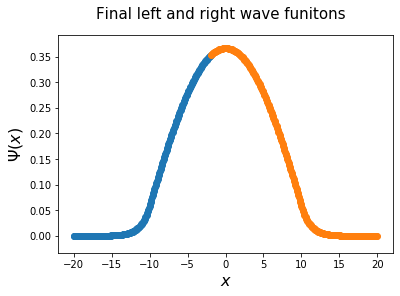

In [19]:
#plotting final wavefunction
%matplotlib inline
fig = plt.figure()
fig.suptitle('Final left and right wave funitons', fontsize=15)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:], (Rwf[icount-1,:,0]))

Good: it appears there is one zero between -15.20 and -14.00. Let's proceed.

Diffmax and Diffmin: -0.7242725857235729 1.5260406086940383

Final eigenvalue E = -14.35841 
iterations =  22


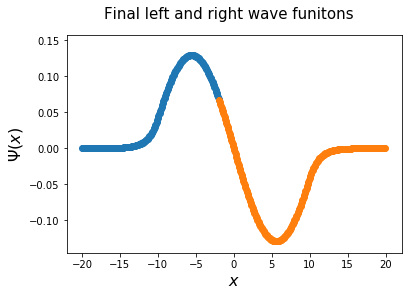

In [20]:
##plotting for second lowest energy eigenvalue

eps = 1e-8

#guess search range
#Emax=-15.5
#Emin=-15.9
Emax=-15.2
Emin=-14
#Emax=-12.5
#Emin=-12.1


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

%matplotlib inline
fig = plt.figure()
fig.suptitle('Final left and right wave funitons', fontsize=15)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:], (Rwf[icount-1,:,0]))

Good: it appears there is one zero between -12.50 and -12.10. Let's proceed.

Diffmax and Diffmin: 4.403076614548743 -3.512342573100319

Final eigenvalue E = -12.32513 
iterations =  21


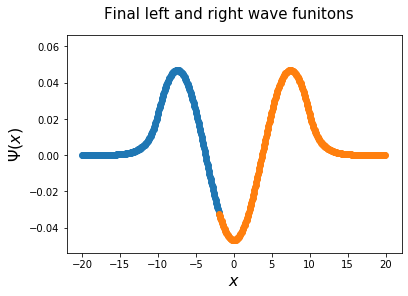

In [21]:
##plotting for third lowest energy eigenvalue

eps = 1e-8

#guess search range
#Emax=-15.5
#Emin=-15.9
#Emax=-15.2
#Emin=-14
Emax=-12.5
Emin=-12.1


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

%matplotlib inline
fig = plt.figure()
fig.suptitle('Final left and right wave funitons', fontsize=15)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:], (Rwf[icount-1,:,0]))

Now we modify the code to study the simple harmonic oscillator, with the following parameters and conditions:
* Let $V(x)=\frac{1}{2}x^2$. In other words, the spring constant, $k=1$.

* Let $\hbar=1$ and $\frac{\hbar^2}{2m}=1$ (in other words, $m=\frac{1}{2}$ in these units).

* Set *xmax=10* (so solutions will be found in the range $x=(-10,10)$).

Again, we find the three lowest-energy states (both eigenvalues and plot the corresponding wave functions).

Given that we know the QM simple harmonic oscillator has allowed energies $E=(n+\frac{1}{2})\hbar\omega$, we know what energy eigenvalues to expect. We can compare your numerical solutions with expectations:

$$E_0 = (1/2)(\sqrt{2}) = 0.7071$$
$$E_1 = (3/2)(\sqrt{2}) = 2.1213$$
$$E_2 = (5/2)(\sqrt{2}) = 3.5355$$



In [22]:
def f(y, x, k2fac,E):
    """Time indep Schrodinger equation
    """
    return [y[1],-k2fac*(E-V(x))*y[0]]


def diff(E, k2fac, xs, imatch, icount, Lwf, Rwf):
# start on the left.
    Lwf[icount,0,0] = 1.e-5                                      
    Lwf[icount,0,1]= Lwf[icount,0,0]*np.sqrt(k2fac*abs(E))
    state = ([Lwf[icount,0,0], Lwf[icount,0,1]])
    Lwf[icount,:,:] = integrate.odeint(f, state, xs[0:len(Lwf[0,:,0])], args=(k2fac,E))
# now the right side. odeint doesn't integrate backwards well, apparently, so flip by hand:
    yb=np.zeros((2,len(Rwf[0,:,0])))
    yb[0,0] = 1.e-5                                      
    yb[0,1]=  yb[0,0]*np.sqrt(k2fac*abs(E)) # no minus sign for the slope, as it's already going backward
    state = ([yb[0,0],yb[0,1]])
    xb=-xs[:(len(Lwf[0,:,0])-2):-1]
    yb = integrate.odeint(f, state,xb, args=(k2fac,E)) # step backward to imatch
    Rwf[icount,:,:]=yb[::-1]
# get the relative normalization right. In effect, the search is really just matching curvatures.
    norma=Lwf[icount,-1,0]/Rwf[icount,0,0]
    Rwf[icount,:,:]=norma*Rwf[icount,:,:]
# calculate logarithmic derivative
    left = Lwf[icount,-1,1]/Lwf[icount,-1,0]        
    right = Rwf[icount,0,1]/Rwf[icount,0,0]                     
    ldif=(left - right)/(left + right)
#    print("left and right:",left,right)
    return ldif, Lwf[icount,:,:], Rwf[icount,:,:]






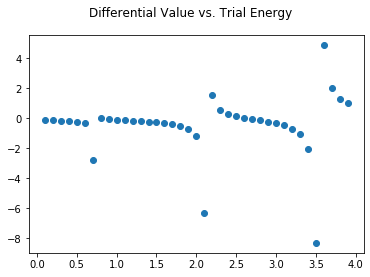

In [23]:
#Look for zeros of differential funciton

def V(x):
    return (1/2)*x*x

xmax = 10
xmatch = 2.5  #x value at which LHS and RHS should match
count_max = 100
k2fac = 1.0
n_steps = 501
h = 2.*xmax/(n_steps - 1)
xs = np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))

#Can get the landscape of zeros locations.
eva = np.arange(0.1,4.,.1)
icount=0
Diffa = np.zeros(len(eva))
for i in range(len(eva)):
    Diffa[i], Lwf[icount,:,:], Rwf[icount,:,:], = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print(eva[i],Diffa[i])
fig = plt.figure()
fig.suptitle('Differential Value vs. Trial Energy')
plt.scatter(eva,Diffa)



We can search for zeros between:

0.6 to 0.8

2.0 to 2.3

3.2 to 3.8

In [24]:
eps = 1e-8

#guess search range
Emax=0.8
Emin=0.6
#Emax=2.3
#Emin=2.0
#Emax=3.8
#Emin=3.2


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

Good: it appears there is one zero between 0.80 and 0.60. Let's proceed.

Diffmax and Diffmin: 0.05049290916461622 -0.31164574098366

Final eigenvalue E = 0.70711 
iterations =  24


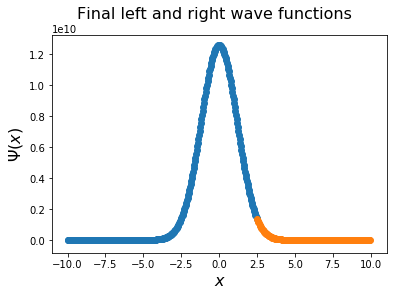

In [56]:
#plot the wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
#plt.ylim(-1.e-4, 1.e-4)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]));

We see this corresponds to the correct lowest harmonic oscillator wavefunction.

In [26]:
eps = 1e-8

#guess search range
#Emax=0.8
#Emin=0.6
Emax=2.3
Emin=2.0
#Emax=3.8
#Emin=3.2


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

Good: it appears there is one zero between 2.30 and 2.00. Let's proceed.

Diffmax and Diffmin: 0.5807772699087019 -1.2043589488240416

Final eigenvalue E = 2.12132 
iterations =  23


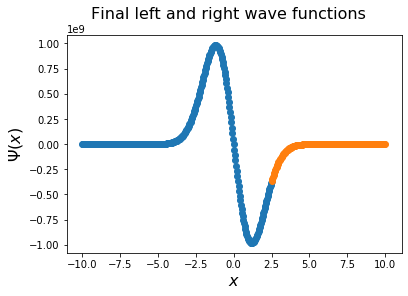

In [27]:
#plot the wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
#plt.ylim(-1.e-3, 1.e-3)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]));

Sweet! The second lowest harmonic oscillator wavefunction.

In [29]:
eps = 1e-8

#guess search range
#Emax=0.8
#Emin=0.6
#Emax=2.3
#Emin=2.0
Emax=3.8
Emin=3.2


icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)
for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)

Good: it appears there is one zero between 3.80 and 3.20. Let's proceed.

Diffmax and Diffmin: 1.3070273855143233 -0.6852167790789577

Final eigenvalue E = 3.53553 
iterations =  24


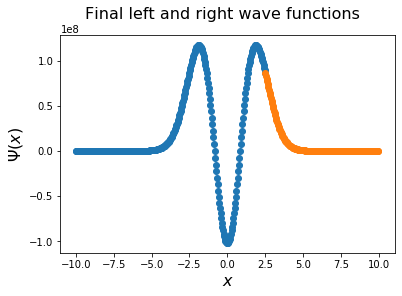

In [30]:
# let's plot the final wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
#plt.ylim(-1.e-3, 1.e-3)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]));

And the third lowest harmonic oscillator wavefunction looks correct as well. 

Now we find the $n=50$ and $n=51$ eigenvalues and plot the associated wave functions. 

$$E_{50} = (101/2)(\sqrt{2}) = 71.478$$
$$E_{51} = (103/2)(\sqrt{2}) = 72.832$$


In [32]:
# parameters 
count_max = 100  # maximun number of search iterations
eps       = 1e-6                                        # Precision
n_steps   = 501                                     # number of (spatial) integration steps
xmax=15.                                                 # set the size of the full +/- x range 
xmatch = 12.      # the x value at which the left and right sides should match
# guess search range
k2fac=1.0
Emax=71.7   
Emin=71

h=2.*xmax/(n_steps-1)
xs=np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for the left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))
#print(Lwf.shape,Rwf.shape)
#we can get the landscape of zeros locations. It would be interesting to change the well depth and width, too.
eva=np.arange(140.,148.,.2)

icount=0
for i in range(len(eva)):
    Diffa, Lwf[icount,:,:], Rwf[icount,:,:] = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print("Energy %.3f and diff value %.3f" %(eva[i],Diffa))
    
# first let's test that we have bracketed the zero
icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
    
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)

for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)


Good: it appears there is one zero between 71.70 and 71.00. Let's proceed.

Diffmax and Diffmin: 0.721346988289766 -0.48523912937949204

Final eigenvalue E = 71.41780 
iterations =  13


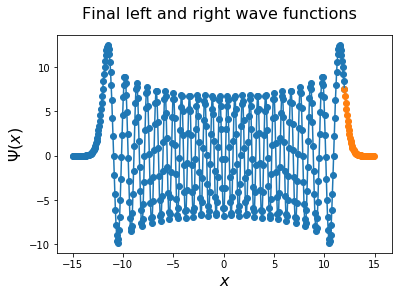

In [34]:
#plot the final wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
#plt.ylim(-1.e-3, 1.e-3)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]))
plt.plot(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.plot(xs[imatch:],(Rwf[icount-1,:,0]))

In [35]:
#parameters 
count_max = 100  # maximun number of search iterations
eps       = 1e-6                                        # Precision
n_steps   = 501                                     # number of (spatial) integration steps
xmax=15.                                                 # set the size of the full +/- x range 
xmatch = 8.      # the x value at which the left and right sides should match
# guess search range
k2fac=1.0
Emax=71.7   
Emin=71

Emax=72.7   
Emin=72.9

h=2.*xmax/(n_steps-1)
xs=np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for the left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))
#print(Lwf.shape,Rwf.shape)
#we can get the landscape of zeros locations. It would be interesting to change the well depth and width, too.
eva=np.arange(135.,145.,.2)

icount=0
for i in range(len(eva)):
    Diffa, Lwf[icount,:,:], Rwf[icount,:,:] = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print("Energy %.3f and diff value %.3f" %(eva[i],Diffa))
    
# first let's test that we have bracketed the zero
icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
    
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)

for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)



Good: it appears there is one zero between 72.70 and 72.90. Let's proceed.

Diffmax and Diffmin: 1.5776926780111924 -4.184811936777326

Final eigenvalue E = 72.83198 
iterations =  11


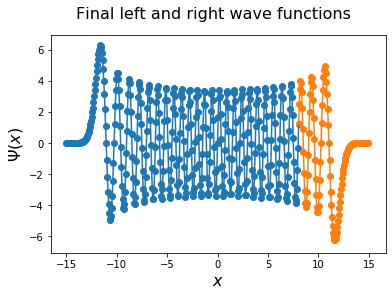

In [36]:
# plot the final wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.xlabel(r'$x$',fontsize=16)
plt.ylabel(r'$\Psi(x)$',fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]))
plt.plot(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.plot(xs[imatch:],(Rwf[icount-1,:,0]))


Investigating the solutions for the potential:

$$V(x)=\lambda x^4 - \mu^2 x^2$$

where $\lambda=0.021$ and $\mu^2=1.5$.

* First we plot the function. This is a one-dimensional variant of the Higgs potential.
* Next, we set *xmatch=0.1, and find the lowest-energy state and energy eigenvalue. Note that we probably will find the lowest-energy wave function that is symmetric about $x=0$. There are actually lower-energy states with the particle primarily localized in either the left or right wells (where the energy is negative). We will try to find some of those lower-energy eigenvalues and plot the accompanying wave function.


Text(0, 0.5, 'V(x)')

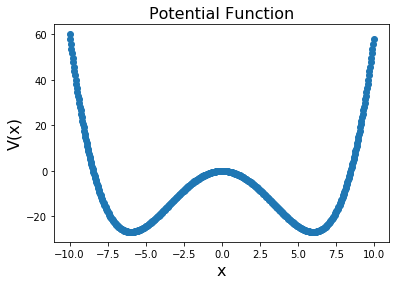

In [37]:
def funct(x):
    lamb=0.021
    musq=1.5
    return lamb*x**4 - musq*x**2

n_steps = 501
xmax = 10.
h = 2.*xmax / (n_steps-1)
xs=np.arange(-xmax,xmax,h)

plt.scatter(xs,funct(xs))
plt.title('Potential Function',fontsize=16)
plt.xlabel('x',fontsize=16)
plt.ylabel('V(x)',fontsize=16)



In [39]:
def V(x):
    lamb=0.021
    musq=1.5
    return lamb*x**4 - musq*x**2


def f(y, x, k2fac,E):
    return [y[1],-k2fac*(E-V(x))*y[0]]



def diff(E, k2fac, xs, imatch, icount, Lwf, Rwf):
# start on the left.
    Lwf[icount,0,0] = 1.e-5                                      
    Lwf[icount,0,1]= Lwf[icount,0,0]*np.sqrt(k2fac*abs(E))
    state = ([Lwf[icount,0,0], Lwf[icount,0,1]])
    Lwf[icount,:,:] = integrate.odeint(f, state, xs[0:len(Lwf[0,:,0])], args=(k2fac,E))
# now the right. odeint doesn't integrate backwards well, apparently, so flip by hand:
    yb=np.zeros((2,len(Rwf[0,:,0])))
    yb[0,0] = 1.e-5                                      
    yb[0,1]=  yb[0,0]*np.sqrt(k2fac*abs(E)) # no minus sign for the slope, as it's already going backward
    state = ([yb[0,0],yb[0,1]])
    xb=-xs[:(len(Lwf[0,:,0])-2):-1]
    yb = integrate.odeint(f, state,xb, args=(k2fac,E)) # step backward to imatch
    Rwf[icount,:,:]=yb[::-1]
# get the relative normalization right. In effect, the search is really just matching curvatures.
    norma=Lwf[icount,-1,0]/Rwf[icount,0,0]
    Rwf[icount,:,:]=norma*Rwf[icount,:,:]
# calculate logarithmic derivative
    left = Lwf[icount,-1,1]/Lwf[icount,-1,0]        
    right = Rwf[icount,0,1]/Rwf[icount,0,0]                     
    ldif=(left - right)/(left + right)
#    print("left and right:",left,right)
    return ldif, Lwf[icount,:,:], Rwf[icount,:,:]

# parameters 
count_max = 100  # maximun number of search iterations
eps       = 1e-6                                        # Precision
n_steps   = 501                                     # number of (spatial) integration steps
xmax=10.                                                 # set the size of the full +/- x range 
xmatch = .1      # the x value at which the left and right sides should match
# guess search range
k2fac=1.0

#Emax=-5.0
#Emin=-7.5
Emax=.9
Emin=.6

h=2.*xmax/(n_steps-1)
xs=np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for the left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))
#print(Lwf.shape,Rwf.shape)
# we can get the landscape of zeros locations. It would be interesting to change the well depth and width, too.
eva=np.arange(140.,148.,.2)

icount=0
for i in range(len(eva)):
    Diffa, Lwf[icount,:,:], Rwf[icount,:,:] = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print("Energy %.3f and diff value %.3f" %(eva[i],Diffa))
## first let's test that we have bracketed the zero

icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
    
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)

for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)



Good: it appears there is one zero between 0.90 and 0.60. Let's proceed.

Diffmax and Diffmin: -0.5812238270798314 0.3728609918787644

Final eigenvalue E = 0.76116 
iterations =  18


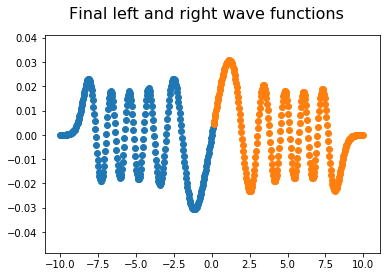

In [40]:
# plot the final wave functions
%matplotlib inline
%matplotlib inline
fig = plt.figure()
#plt.ylim(-1.e-3, 1.e-3)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]));

Good: it appears there is one zero between 0.20 and 0.10. Let's proceed.

Diffmax and Diffmin: 3.972045768989119 -6.635814792030636

Final eigenvalue E = 0.13878 
iterations =  19


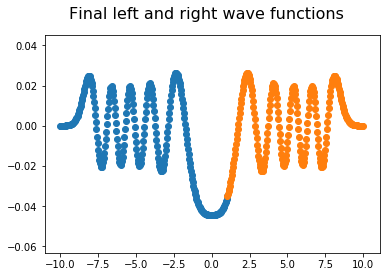

In [42]:
def V(x):
    lamb=0.021
    musq=1.5
    return lamb*x**4 - musq*x**2


def f(y, x, k2fac,E):
    return [y[1],-k2fac*(E-V(x))*y[0]]



def diff(E, k2fac, xs, imatch, icount, Lwf, Rwf):
# start on the left.
    Lwf[icount,0,0] = 1.e-5                                      
    Lwf[icount,0,1]= Lwf[icount,0,0]*np.sqrt(k2fac*abs(E))
    state = ([Lwf[icount,0,0], Lwf[icount,0,1]])
    Lwf[icount,:,:] = integrate.odeint(f, state, xs[0:len(Lwf[0,:,0])], args=(k2fac,E))
# now the right. odeint doesn't integrate backwards well, apparently, so flip by hand:
    yb=np.zeros((2,len(Rwf[0,:,0])))
    yb[0,0] = 1.e-5                                      
    yb[0,1]=  yb[0,0]*np.sqrt(k2fac*abs(E)) # no minus sign for the slope, as it's already going backward
    state = ([yb[0,0],yb[0,1]])
    xb=-xs[:(len(Lwf[0,:,0])-2):-1]
    yb = integrate.odeint(f, state,xb, args=(k2fac,E)) # step backward to imatch
    Rwf[icount,:,:]=yb[::-1]
# get the relative normalization right. In effect, the search is really just matching curvatures.
    norma=Lwf[icount,-1,0]/Rwf[icount,0,0]
    Rwf[icount,:,:]=norma*Rwf[icount,:,:]
# calculate logarithmic derivative
    left = Lwf[icount,-1,1]/Lwf[icount,-1,0]        
    right = Rwf[icount,0,1]/Rwf[icount,0,0]                     
    ldif=(left - right)/(left + right)
#    print("left and right:",left,right)
    return ldif, Lwf[icount,:,:], Rwf[icount,:,:]

# parameters
count_max = 100  # maximun number of search iterations
eps       = 1e-6                                        # Precision
n_steps   = 501                                     # number of (spatial) integration steps
xmax=10.                                                 # set the size of the full +/- x range 
xmatch = 1      # the x value at which the left and right sides should match
# guess search range
k2fac=1.0

Emax=.2   
Emin=.1
#Emax=-5.0
#Emin=-7.5
#Emax=.9
#Emin=.6

h=2.*xmax/(n_steps-1)
xs=np.arange(-xmax,xmax,h)
imatch=np.nonzero((xs>xmatch))[0][0]
# arrays for the left and right wf(index 0) and wf'(index 1)
Lwf = np.zeros((count_max,imatch+1,2))   # we need these to overlap at one point, so add 1 more Lwf.       
Rwf = np.zeros((count_max,n_steps-imatch-1,2))
#print(Lwf.shape,Rwf.shape)

# we can get the landscape of zeros locations. It would be interesting to change the well depth and width, too.
eva=np.arange(140.,148.,.2)
icount=0
for i in range(len(eva)):
    Diffa, Lwf[icount,:,:], Rwf[icount,:,:] = diff(eva[i], k2fac, xs, imatch, icount, Lwf, Rwf)
    #print("Energy %.3f and diff value %.3f" %(eva[i],Diffa))
# first let's test that we have bracketed the zero

icount=0
Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
Diffmin, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emin, k2fac, xs, imatch, icount, Lwf, Rwf)
if ((Diffmax*Diffmin)>0) : 
    print("\n\n\n WHOOOOPS looks as if there is not one zero in this range\n\n\n",Diffmax,Diffmin)
    sys.exit()
    
print("Good: it appears there is one zero between %.2f and %.2f. Let's proceed.\n"%(Emax,Emin))
print("Diffmax and Diffmin:",Diffmax,Diffmin)

for icount in range(0,count_max+1):
    # Iteration loop
    E = (Emax + Emin)/2.                                 # Divide E range
    Diffmax, Lwf[icount,:,:], Rwf[icount,:,:] = diff(Emax, k2fac, xs, imatch, icount, Lwf, Rwf)
    Diff, Lwf[icount,:,:], Rwf[icount,:,:] = diff(E, k2fac, xs, imatch, icount, Lwf, Rwf) 
    if (Diffmax*Diff > 0):  Emax = E          # Bisection algorithm
    else:                         Emin = E     
    if (abs((Emax-Emin)/E)  <  eps ):     break
    #print("Count: %d   Energy: %.5f    Diff %.2f "%(icount, E, Diff))

print("\nFinal eigenvalue E = %.5f "%E)
print("iterations = ",icount)


fig = plt.figure()
#plt.ylim(-1.e-3, 1.e-3)
fig.suptitle('Final left and right wave functions', fontsize=16)
plt.scatter(xs[0:imatch+1],(Lwf[icount-1,:,0]))
plt.scatter(xs[imatch:],(Rwf[icount-1,:,0]));

Nice. Looks like we have found a couple lower level energy eigenvalues and their wave functions.